In [1]:
#Load necessary libraries
import numpy as np
import pandas as pd
import missingpy
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression


C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from impyute.imputation.cs import mice
import matplotlib.pyplot as plt

In [3]:
#Load necessary data files 
#Date column gets converted into date type
train = pd.read_csv("train.csv",parse_dates=['date'])
test = pd.read_csv("test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
Unnamed: 0        int64
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 156.8 MB


In [5]:
#Drop the unnamed column for train set
train.drop(train.columns[0], axis=1, inplace=True)

In [6]:
#Drop the unnamed column for test set
test.drop(test.columns[0], axis=1, inplace=True)

In [7]:
#Update train set to include only stores and items that show up in test set
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
train2 = train[train['shop_id'].isin(test_shop_ids)]
train2 = train2[train2['item_id'].isin(test_item_ids)]

In [8]:
#Check missing values
train2.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [9]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [10]:
#Output train set
train2.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,1.224439e+06,1.224439e+06,1.224439e+06,1.224439e+06,1.224439e+06
mean,1.935472e+01,3.215117e+01,9.614866e+03,1.030666e+03,1.321234e+00
std,9.110722e+00,1.646562e+01,6.299870e+03,1.827384e+03,3.312997e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,5.000000e-01,-1.600000e+01
25%,1.200000e+01,1.900000e+01,4.181000e+03,2.990000e+02,1.000000e+00
50%,2.100000e+01,3.100000e+01,7.856000e+03,5.490000e+02,1.000000e+00
75%,2.700000e+01,4.600000e+01,1.522900e+04,1.199000e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,5.920000e+04,2.169000e+03


In [11]:
#Remove observations with negative item_price and negative item_cnt_day
train2 =train2.query('item_price > 0')
train2 = train2.query('item_cnt_day >= 0')

In [12]:
#Update train set to represent monthly data
#Sort by date
train2 = train2.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train2 = train2.agg({'item_price':['mean'], 'item_cnt_day':['sum']})
train2.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price_month_avg', 'item_cnt_month_current']

In [13]:
#Update train dataframe to have all groups of dates, shops and items
shops = train2['shop_id'].unique()
items = train2['item_id'].unique()
temp = []
for i in range(34):
    for shop in shops:
        for item in items:
            temp.append([i, shop, item])
    
temp = pd.DataFrame(temp, columns=['date_block_num','shop_id','item_id'])

In [14]:
#Combine temp with train2 to create new train set 
#Decision was made to place 0 for any missing values
train3 = pd.merge(temp, train2, on=['date_block_num','shop_id','item_id'], how='left')
train3.fillna(0, inplace=True)

In [15]:
#Check for missing values in updated train set
train3.isna().sum()

date_block_num            0
shop_id                   0
item_id                   0
item_price_month_avg      0
item_cnt_month_current    0
dtype: int64

In [16]:
train3.describe()

,date_block_num,shop_id,item_id,item_price_month_avg,item_cnt_month_current
count,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06
mean,1.650000e+01,3.164286e+01,1.104189e+04,8.115462e+01,2.406726e-01
std,9.810709e+00,1.756189e+01,6.210744e+03,5.340378e+02,3.457185e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00
25%,8.000000e+00,1.600000e+01,5.385250e+03,0.000000e+00,0.000000e+00
50%,1.650000e+01,3.450000e+01,1.126550e+04,0.000000e+00,0.000000e+00
75%,2.500000e+01,4.700000e+01,1.606825e+04,0.000000e+00,0.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,4.299000e+04,2.253000e+03


In [17]:
#Create new column that represents next month's forecasts
train3['item_cnt_month_fcast'] = train3.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month_current'].shift(-1)

In [41]:
#Update train set based on date_block_num
#train set will be 0 - 32 
train_df = train3.query('date_block_num >=0 and date_block_num < 33')
#Subset train_df into predictor variables and label 
train_X = train_df.drop(['item_cnt_month_fcast'], axis=1)
train_Y = train_df['item_cnt_month_fcast']

In [42]:
#Update test set
#It is the combination of the original test object created during the data load and the train set without duplicates
temp2 = train_df.drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
test_x = pd.merge(test, temp2, on =["shop_id", "item_id"], how="left")
#Drop item_cnt_month_fcast
test_x.drop('item_cnt_month_fcast', axis=1, inplace=True)

In [43]:
#Change date_block_num to 33 
test_x.drop('date_block_num', axis=1, inplace=True)
test_x.insert(1, 'date_block_num',  33)

In [44]:
#Drop ID from test_x
test_x.drop('ID', axis=1, inplace=True)

In [45]:
test_x.head()

,date_block_num,shop_id,item_id,item_price_month_avg,item_cnt_month_current
0,33,5,5037,749.5,1.0
1,33,5,5320,NaN,NaN
2,33,5,5233,999.0,3.0
3,33,5,5232,0.0,0.0
4,33,5,5268,NaN,NaN


In [46]:
test_x.isnull().sum()

date_block_num                0
shop_id                       0
item_id                       0
item_price_month_avg      16128
item_cnt_month_current    16128
dtype: int64

In [47]:
#Impute missing values using KNN
test_x_imp=mice(test_x)

C:\Anaconda\lib\site-packages\impyute\util\preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()


In [48]:
#Build XGBoost Model
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 20, seed=1)

In [49]:
#Fit the xgb model 
xgb_reg.fit(train_X, train_Y)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [50]:
#Make predictions using xgb_reg model
xgb_preds = xgb_reg.predict(train_X)

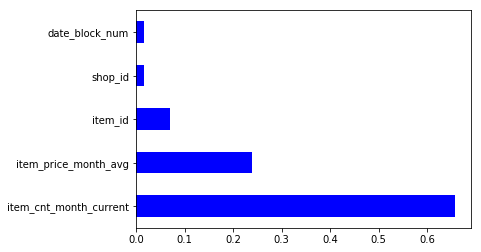

In [51]:
feat_importances2 = pd.Series(xgb_reg.feature_importances_, index=train_X.columns)
feat_importances2.nlargest(5).plot(kind='barh', color='blue')

In [52]:
#Calculate RMSE 
xgb_rmse = np.sqrt(mean_squared_error(train_Y, xgb_preds))
print("XGB RMSE: %f" % (xgb_rmse))

XGB RMSE: 2.843208


In [53]:
#Build RF Model 
rf_reg = RandomForestRegressor(n_estimators = 20, max_depth = 5, random_state=2 )

In [54]:
#Fit the rf model 
rf_reg.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [55]:
#Make predictions using rf_reg model
rf_preds = rf_reg.predict(train_X)

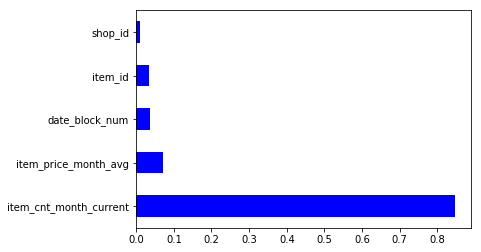

In [56]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=train_X.columns)
feat_importances.nlargest(5).plot(kind='barh', color='blue')

In [57]:
#Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(train_Y, rf_preds))
print("RF RMSE: %f" % (rf_rmse))

RF RMSE: 2.017180


In [58]:
#Build Linear Regression Model
l_reg = LinearRegression()

In [59]:
#Fit the lr model
l_reg.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
list(zip(train_X.columns, l_reg.coef_))

[('date_block_num', 0.0018017306580143683),
 ('shop_id', 3.134966490962332e-05),
 ('item_id', -1.8701151694805715e-06),
 ('item_price_month_avg', -0.00016206934711500087),
 ('item_cnt_month_current', 0.7702867428488376)]

In [61]:
print(l_reg.intercept_)

0.06475997678545795


In [62]:
#Make predictions using l_reg model
lr_preds = l_reg.predict(train_X)

In [63]:
#Calculate RMSE
lr_rmse = np.sqrt(mean_squared_error(train_Y, lr_preds))
print("LR RMSE: %f" % (lr_rmse))

LR RMSE: 2.370815


In [64]:
#Going to use RF Model for test_x_imp data set
submission_preds = rf_reg.predict(test_x_imp)

In [65]:
#Output the submission file 
submissions = pd.DataFrame(test['ID'], columns=['ID'])
submissions['item_cnt_month'] = submission_preds

In [66]:
#Write to csv
submissions.to_csv('submission.csv', index=False)

In [67]:
#View the final results
submissions.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.294852
std,61834.358168,2.969003
min,0.000000,0.095431
25%,53549.750000,0.095431
50%,107099.500000,0.095431
75%,160649.250000,0.095431
max,214199.000000,876.470175
